## Install and Setup a Spark session.

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=daf0a3f88c77cc2a6fadc61d78ac976ce4550c8faaf4737eb139b3429641eb18
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Weather Analysis").getOrCreate()

## <b>1 <span style='color:#0386f7de'>|</span> Reading and Understanding the Datasets</b>

In [3]:
df_weather = spark.read.csv('LCD_sample.csv', header=True, inferSchema=True)
df_weather.show(5)


+----------+--------------------+---------+--------+---------+-------------+----------+-------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+-----------------+-------------------

## <b>2 <span style='color:#0386f7de'>|</span> Data Cleaning</b>

In [4]:
df_weather.count()

772

**Indeed non-null and non-NaN values**

In [5]:
from pyspark.sql.functions import isnan, when, count, col

# Count non-NaN values for each field
df_weather.select([count(when(~isnan(c) & ~col(c).isNull(), c)).alias(c) for c in ["HourlyDryBulbTemperatureF", "HourlyRelativeHumidity"]]).show()


+-------------------------+----------------------+
|HourlyDryBulbTemperatureF|HourlyRelativeHumidity|
+-------------------------+----------------------+
|                      742|                   742|
+-------------------------+----------------------+



**Check for Empty Strings**

In [6]:
# Replace empty strings with nulls in specified columns and display the DataFrame
df = df_weather \
    .withColumn("HourlyDryBulbTemperatureF", when(col("HourlyDryBulbTemperatureF") == "", None).otherwise(col("HourlyDryBulbTemperatureF"))) \
    .withColumn("HourlyRelativeHumidity", when(col("HourlyRelativeHumidity") == "", None).otherwise(col("HourlyRelativeHumidity")))

# Show the DataFrame in an organized manner
df.show(truncate=False, n=5)



+----------+-----------------------------------------+---------+--------+---------+-------------+----------+-------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+----------------

**Fill Missing Values**

In [7]:
df = df_weather.na.fill({"HourlyDryBulbTemperatureF": 0, "HourlyRelativeHumidity": 0})


**Create our pipeline**

In [8]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyRelativeHumidity"],
    outputCols=["HourlyDryBulbTemperatureF_imputed", "HourlyRelativeHumidity_imputed"]
).setStrategy("median")


In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer

assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF_imputed", "HourlyRelativeHumidity_imputed"],
    outputCol="features"
)

# Define StandardScaler to scale the numerical features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

In [10]:
# Define the pipeline which consists of stages
pipeline = Pipeline(stages=[imputer, assembler, scaler])

# Now you can fit and transform your pipeline
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

In [11]:
# Show the results of the transformation
df_transformed.show()

+----------+--------------------+---------+--------+---------+--------------+----------+--------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+-----------------+-----------------

# Performing EDA for visibilty and weather conditions

In [12]:
df.select('HourlyDryBulbTemperatureF').describe().show()
df.select('HourlyDryBulbTemperatureC').describe().show()


+-------+-------------------------+
|summary|HourlyDryBulbTemperatureF|
+-------+-------------------------+
|  count|                      772|
|   mean|        30.39896373056995|
| stddev|       13.430568882482735|
|    min|                       -1|
|    max|                       67|
+-------+-------------------------+

+-------+-------------------------+
|summary|HourlyDryBulbTemperatureC|
+-------+-------------------------+
|  count|                      742|
|   mean|     -0.20835579514824798|
| stddev|        6.778429727720414|
|    min|                    -18.3|
|    max|                     19.4|
+-------+-------------------------+



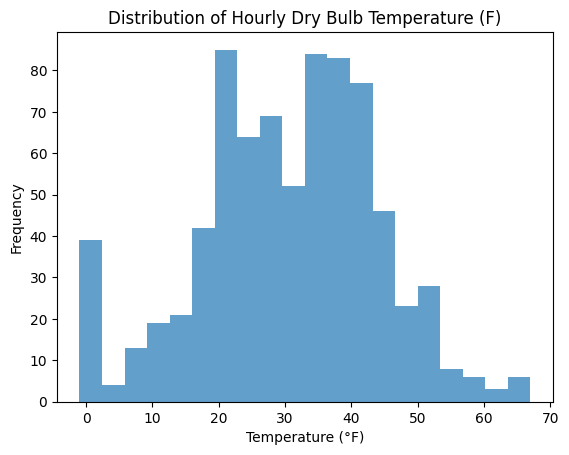

In [13]:
import matplotlib.pyplot as plt

# Assuming 'HourlyDryBulbTemperatureF' is within a Pandas DataFrame for visualization
df_pd = df.toPandas()  # Convert Spark DataFrame to Pandas DataFrame for plotting
plt.hist(df_pd['HourlyDryBulbTemperatureF'], bins=20, alpha=0.7)
plt.title('Distribution of Hourly Dry Bulb Temperature (F)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


In [14]:
from pyspark.sql.functions import col

df = df.withColumn("HourlyPrecipitation", col("HourlyPrecipitation").cast("float"))
df.printSchema()  # Check to ensure the conversion was successful


root
 |-- STATION: string (nullable = true)
 |-- STATION_NAME: string (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- DATE: string (nullable = true)
 |-- reportType: string (nullable = true)
 |-- HourlySkyConditions: string (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- HourlyPresentWeatherType: string (nullable = true)
 |-- HourlyDryBulbTemperatureF: integer (nullable = false)
 |-- HourlyDryBulbTemperatureC: double (nullable = true)
 |-- HourlyWetBulbTemperatureF: integer (nullable = true)
 |-- HourlyWetBulbTemperatureC: double (nullable = true)
 |-- HourlyDewPointTemperatureF: integer (nullable = true)
 |-- HourlyDewPointTemperatureC: double (nullable = true)
 |-- HourlyRelativeHumidity: integer (nullable = false)
 |-- HourlyWindSpeed: integer (nullable = true)
 |-- HourlyWindDirection: string (nullable = true)
 |-- HourlyWindGustSpeed: integer (nullable = true)
 |

In [15]:
correlation_value = df.stat.corr('HourlyDryBulbTemperatureF', 'HourlyPrecipitation')
print(f"Correlation between Temperature and Precipitation: {correlation_value}")


Correlation between Temperature and Precipitation: 0.003949929727518378


In [16]:
from pyspark.sql.functions import log, col

# Assuming 'HourlyPrecipitation' has no zero or negative values; otherwise, adjust it first
df = df.withColumn("LogHourlyPrecipitation", log(col("HourlyPrecipitation") + 1))  # Adding 1 to avoid log(0)

# Check new correlation
new_correlation = df.stat.corr('HourlyDryBulbTemperatureF', 'LogHourlyPrecipitation')
print(f"New Correlation between Temperature and Log of Precipitation: {new_correlation}")


New Correlation between Temperature and Log of Precipitation: 0.003620591388232587


In [17]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan('HourlyPrecipitation') | col('HourlyPrecipitation').isNull(), 'HourlyPrecipitation')).alias('MissingValues')]).show()


+-------------+
|MissingValues|
+-------------+
|          721|
+-------------+



In [18]:
df_clean = df.na.drop(subset=["HourlyPrecipitation"])
print("Remaining rows:", df_clean.count())


Remaining rows: 51


In [25]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["HourlyPrecipitation"],
    outputCols=["HourlyPrecipitationImputed"]
).setStrategy("mean")  # You can also use "median" or "mode"

df_imputed = imputer.fit(df).transform(df)
df_imputed

DataFrame[STATION: string, STATION_NAME: string, ELEVATION: double, LATITUDE: double, LONGITUDE: double, DATE: string, reportType: string, HourlySkyConditions: string, HourlyVisibility: double, HourlyPresentWeatherType: string, HourlyDryBulbTemperatureF: int, HourlyDryBulbTemperatureC: double, HourlyWetBulbTemperatureF: int, HourlyWetBulbTemperatureC: double, HourlyDewPointTemperatureF: int, HourlyDewPointTemperatureC: double, HourlyRelativeHumidity: int, HourlyWindSpeed: int, HourlyWindDirection: string, HourlyWindGustSpeed: int, HourlyStationPressure: double, HourlyPressureTendency: int, HourlyPressureChange: double, HourlySeaLevelPressure: string, HourlyPrecipitation: float, HourlyAltimeterSetting: double, DailyMaximumDryBulbTemperature: int, DailyMinimumDryBulbTemperature: int, DailyAverageDryBulbTemperature: int, DailyDepartureFromNormalAverageTemperature: double, DailyAverageRelativeHumidity: int, DailyAverageDewPointTemperature: string, DailyAverageWetBulbTemperature: int, Daily

In [26]:
from pyspark.sql.functions import col

# Assuming you know the columns or detect them dynamically
columns_to_fill = ["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"]
fill_values = {col: 0 for col in columns_to_fill}  # Replace '0' with an appropriate value for your context
df_filled = df_imputed.na.fill(fill_values)

# Now use df_filled to fit the model
model = pipeline.fit(df_filled)


In [27]:
for column in columns_to_fill:
    null_count = df_imputed.where(col(column).isNull()).count()
    print(f"Nulls in {column}: {null_count}")


Nulls in HourlyDryBulbTemperatureF: 0
Nulls in HourlyWindSpeed: 30
Nulls in HourlyRelativeHumidity: 0


# Decision Tree model

In [28]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features"
)


In [29]:
from pyspark.ml.regression import DecisionTreeRegressor

# For a regression problem
dt = DecisionTreeRegressor(featuresCol="features", labelCol="HourlyPrecipitationImputed")

# If it was a classification problem, you'd use:
# from pyspark.ml.classification import DecisionTreeClassifier
# dt = DecisionTreeClassifier(featuresCol="features", labelCol="TargetColumn")


In [33]:
# Columns used in the model
columns_to_fill = ["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"]
fill_values = {col: df_imputed.agg({col: "mean"}).first()[0] for col in columns_to_fill}  # Using mean to fill

# Filling null values
df_imputed_filled = df_imputed.fillna(fill_values)

# Recreate the pipeline and fit the model using the filled DataFrame
pipeline = Pipeline(stages=[assembler, dt])
model = pipeline.fit(df_imputed_filled)


In [34]:
from pyspark.ml.feature import VectorAssembler

# Configure VectorAssembler with a strategy to handle nulls
assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features",
    handleInvalid="skip"  # This will skip rows with any null values
)

# Update the pipeline
pipeline = Pipeline(stages=[assembler, dt])
model = pipeline.fit(df_imputed_filled)


In [35]:
# Make predictions
predictions = model.transform(df_imputed_filled)

# Show predictions
predictions.select("features", "HourlyPrecipitationImputed", "prediction").show(5)

# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="HourlyPrecipitationImputed",
    predictionCol="prediction",
    metricName="rmse"
)

# Calculate RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


+----------------+--------------------------+--------------------+
|        features|HourlyPrecipitationImputed|          prediction|
+----------------+--------------------------+--------------------+
| [30.0,9.0,56.0]|               0.030980391|0.030980391427874565|
| [30.0,0.0,58.0]|               0.030980391|0.030980391427874565|
| [29.0,8.0,72.0]|               0.030980391| 0.02987179418022816|
| [28.0,0.0,81.0]|                      0.03|0.030951556366156128|
|[26.0,11.0,78.0]|                      0.01| 0.01777777738041348|
+----------------+--------------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.003288441194758109


In [36]:
print(model.stages[-1].toDebugString)


DecisionTreeRegressionModel: uid=DecisionTreeRegressor_e6458012eee9, depth=5, numNodes=43, numFeatures=3
  If (feature 2 <= 81.5)
   If (feature 2 <= 71.5)
    If (feature 2 <= 67.5)
     Predict: 0.030980391427874565
    Else (feature 2 > 67.5)
     If (feature 0 <= 12.5)
      If (feature 1 <= 6.5)
       Predict: 0.030980391427874565
      Else (feature 1 > 6.5)
       Predict: 0.01699346366027991
     Else (feature 0 > 12.5)
      If (feature 0 <= 26.5)
       Predict: 0.029814814113908343
      Else (feature 0 > 26.5)
       Predict: 0.030980391427874565
   Else (feature 2 > 71.5)
    If (feature 1 <= 10.5)
     If (feature 0 <= 42.5)
      If (feature 1 <= 7.5)
       Predict: 0.030951556366156128
      Else (feature 1 > 7.5)
       Predict: 0.02987179418022816
     Else (feature 0 > 42.5)
      If (feature 2 <= 76.5)
       Predict: 0.030980391427874565
      Else (feature 2 > 76.5)
       Predict: 0.009999999776482582
    Else (feature 1 > 10.5)
     If (feature 0 <= 26.5)
    